# PyTorch and fastai implementations of Adam

In [1]:
from fastai2.vision.all import *
from fastai2.callback.fp16 import *

## Data

In [2]:
path = untar_data(URLs.IMAGENETTE)
Path.BASE_PATH = path
path.ls()

(#2) [Path('val'),Path('train')]

In [12]:
get_image_files(path/'train')

(#9469) [Path('train/n03028079/n03028079_7077.JPEG'),Path('train/n03028079/n03028079_1667.JPEG'),Path('train/n03028079/n03028079_3728.JPEG'),Path('train/n03028079/n03028079_5073.JPEG'),Path('train/n03028079/n03028079_2035.JPEG'),Path('train/n03028079/n03028079_28505.JPEG'),Path('train/n03028079/n03028079_23916.JPEG'),Path('train/n03028079/n03028079_56388.JPEG'),Path('train/n03028079/n03028079_28243.JPEG'),Path('train/n03028079/n03028079_16749.JPEG')...]

In [13]:
get_image_files(path/'val')

(#3925) [Path('val/n03028079/ILSVRC2012_val_00034021.JPEG'),Path('val/n03028079/n03028079_31602.JPEG'),Path('val/n03028079/n03028079_2782.JPEG'),Path('val/n03028079/n03028079_50060.JPEG'),Path('val/n03028079/n03028079_13981.JPEG'),Path('val/n03028079/n03028079_38700.JPEG'),Path('val/n03028079/n03028079_25542.JPEG'),Path('val/n03028079/n03028079_3670.JPEG'),Path('val/n03028079/n03028079_11401.JPEG'),Path('val/n03028079/n03028079_21591.JPEG')...]

In [14]:
dataset_sizes = {x: len(get_image_files(path/x)) for x in ['train', 'val']}
dataset_sizes

{'train': 9469, 'val': 3925}

In [3]:
(path/'train').ls()

(#10) [Path('train/n03028079'),Path('train/n02102040'),Path('train/n03000684'),Path('train/n01440764'),Path('train/n03888257'),Path('train/n03425413'),Path('train/n02979186'),Path('train/n03394916'),Path('train/n03417042'),Path('train/n03445777')]

In [4]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter(valid_name='val'),
    item_tfms=Resize(460),
    batch_tfms=[*aug_transforms(size=224, min_scale=0.75),
                Normalize.from_stats(*imagenet_stats)])

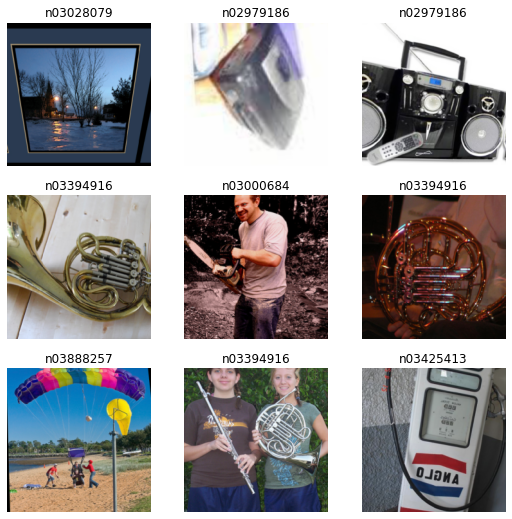

In [5]:
dls = dblock.dataloaders(path)
dls.show_batch()

### Model

In [6]:
model = xresnet50(n_out=dls.c)

## fastai implementation using optimizer callbacks

In [7]:
def timestep(p, ts=0, **kwargs):
    ts += 1 
    return {'ts': ts}

In [8]:
def first_moment(p, beta1, grad_avg=None, **kwargs):
    if grad_avg is None: grad_avg = torch.zeros_like(p.grad.data)
    return {'grad_avg': beta1*grad_avg + (1-beta1)*p.grad.data}

In [9]:
def second_moment(p, beta2, ts, sq_avg=None, **kwargs):
    if sq_avg is None: sq_avg = torch.zeros_like(p.grad.data)
    return {'sq_avg': beta2*sq_avg + (1-beta2)*(p.grad.data**2)}

In [10]:
def debias(beta, ts):
    return 1 - beta**ts

In [11]:
def my_adam_step(p, lr, eps, beta1, beta2, ts, grad_avg, sq_avg, **kwargs):
    debias1 = debias(beta1, ts)
    debias2 = debias(beta2, ts)
    denom = (sq_avg/debias2).sqrt().add_(eps)
    p.data.addcdiv_(-lr, grad_avg/debias1, denom)

In [12]:
opt_func = partial(Optimizer, cbs=[timestep, first_moment, second_moment, my_adam_step],
                   beta1=0.9, beta2=0.99, eps=1e-5)

### create and train learner

In [13]:
learn = Learner(dls, model, opt_func=opt_func, metrics=accuracy).to_fp16()

SuggestedLRs(lr_min=0.10964782238006592, lr_steep=0.9120108485221863)

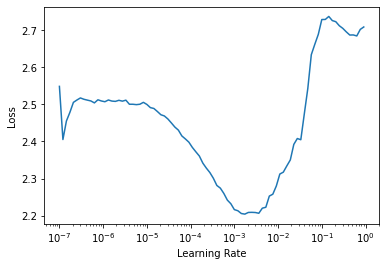

In [14]:
learn.lr_find()

In [15]:
lr=3e-4

In [16]:
learn.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.755654,1.630159,0.459363,01:30
1,1.388343,1.426804,0.535796,01:30
2,1.176869,1.222022,0.607389,01:30
3,1.034125,1.166533,0.630318,01:30
4,0.916284,1.060758,0.686624,01:30
5,0.781182,0.924197,0.719745,01:30
6,0.710942,0.855331,0.734013,01:30
7,0.630623,0.700613,0.787771,01:31
8,0.573993,0.650000,0.799236,01:30
9,0.564432,0.642295,0.802548,01:30


## PyTorch Implementation

In [1]:
class Adam(torch.optim.Optimizer):
    def __init__(self, params, lr, betas=(0.9, 0.999), eps=1e-8, wd=0., 
                 decouple_wd=True, correct_bias=True):
        defaults = dict(lr=lr, betas=betas, eps=eps, wd=wd, 
                        decouple_wd=decouple_wd, correct_bias=correct_bias)
        super(Adam, self).__init__(params, defaults)
    
    def step(self, closure=None):
        for group in self.param_groups:
            for p in group['params']:
                beta1, beta2 = group['betas']
                lr, wd = group['lr'], group['wd']
                
                # ie. parameter is freezed
                if p.grad is None: continue
                grad = p.grad.data
                
                # use original weight decay formulation
                if group['decouple_wd']:
                    p.data.mul_(1 - lr*wd)
                else: # use l2 regularization equivalent
                    grad.add_(wd, p.data)
                    
                state = self.state[p]
                # ie. if this is the first time we're acessing the state of that parameter
                if len(state) == 0:
                    state['grad_avg'] = torch.zeros_like(grad)
                    state['sq_avg'] = torch.zeros_like(grad)
                    state['ts'] = 0

                state['ts'] += 1
                grad_avg = state['grad_avg']
                sq_avg = state['sq_avg']
                

                # calculate and updatae exponential moving aveages
                grad_avg.mul_(beta1).add_(1-beta1, grad)
                sq_avg.mul_(beta2).addcmul_(1-beta2, grad, grad)

                if group['correct_bias']:
                    # apply bias correction to the lr insted of applying
                    # it directly to the moving averages
                    bias1 = 1 - beta1**state['ts']
                    bias2 = 1 - beta2**state['ts']
                    lr = lr * math.sqrt(bias2) / bias1

                denom = sq_avg.sqrt().add_(group['eps'])    
                p.data.addcdiv_(-lr, grad_avg, denom)         

NameError: name 'torch' is not defined

retrain model

In [19]:
from training_loop import train_model

In [20]:
model = xresnet50(n_out=dls.c)

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = Adam(model.parameters(), 3e-4, betas=(0.9, 0.99), eps=1e-5)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [23]:
model = train_model(dls, model, criterion, optimizer, exp_lr_scheduler,
                    device, dataset_sizes, num_epochs=5)

Epoch 0/4
----------


NameError: name 'dataset_sizes' is not defined